In [38]:
from typing import Iterable, Tuple
import joblib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


In [39]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
0,ConcertExperience_180106,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,concert_goer_1985,140.0,Paraguay,Did Not Enjoy
1,ConcertExperience_146268,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,concert_goer_1874,158.0,United Kingdom (UK),Enjoyed
2,ConcertExperience_128743,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,concert_goer_442,159.0,United States of America (USA),Did Not Enjoy
3,ConcertExperience_140839,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,concert_goer_1149,150.0,Canada,Worst Concert Ever
4,ConcertExperience_19149,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,concert_goer_930,166.0,United Kingdom (UK),Did Not Enjoy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,ConcertExperience_14055,Crazy Joystick Cult,RnB,Canada,1985.0,70.0,162754.0,True,False,False,-0.095021,0.175175,0.914245,0.357359,50.0,concert_goer_707,180.0,United States of America (USA),Did Not Enjoy
169996,ConcertExperience_192792,Crazy Joystick Cult,RnB,Canada,1985.0,963.0,54.0,False,False,False,-0.733719,-0.285776,-0.323312,0.641180,71.0,concert_goer_1373,143.0,Bulgaria,Worst Concert Ever
169997,ConcertExperience_152942,"Why Frogs, Why?",Heavy Metal,Canada,2005.0,764.0,54.0,False,False,False,0.744969,-0.965547,1.020598,1.027389,27.0,concert_goer_1286,176.0,Canada,Did Not Enjoy
169998,ConcertExperience_138957,Twilight of the Joystick Gods,Hip Hop/Rap,United States of America (USA),1995.0,694.0,22026.0,False,True,True,0.821976,0.351411,0.175762,1.455654,39.0,concert_goer_1845,176.0,Canada,Did Not Enjoy


In [40]:
# train data statistics
value = train_data.mode().loc[0] # most frequent strategy

# fill nan values
train_data.fillna(value=value, inplace=True)
test_data.fillna(value=value, inplace=True)

# convert Concert ID to string
train_data['Concert ID'] = train_data['Concert ID'].map(lambda x: str(x))
test_data['Concert ID'] = test_data['Concert ID'].map(lambda x: str(x))

In [41]:
train_data['Concert Goer ID'].unique().size

2000

In [4]:
target_transform = {
    'Worst Concert Ever': 0,
    'Did Not Enjoy': 1,
    'Enjoyed': 2,
    'Best Concert Ever': 3
}

target_inverse_transform = {
    0: 'Worst Concert Ever',
    1: 'Did Not Enjoy',
    2: 'Enjoyed',
    3: 'Best Concert Ever'
}

train_data['Concert Enjoyment'] = train_data['Concert Enjoyment'].map(target_transform)

# fit custom transforms on train data
concert_id_transform = train_data[['Concert ID', 'Concert Enjoyment']].groupby(['Concert ID']).mean()['Concert Enjoyment']
concert_goer_id_transform = train_data[['Concert Goer ID', 'Concert Enjoyment']].groupby(['Concert Goer ID']).mean()['Concert Enjoyment']

# apply custom transforms on train and test data
train_data['Concert ID'] = train_data['Concert ID'].map(concert_id_transform)
train_data['Concert Goer ID'] = train_data['Concert Goer ID'].map(concert_goer_id_transform)

test_data['Concert ID'] = test_data['Concert ID'].map(concert_id_transform)
test_data['Concert Goer ID'] = test_data['Concert Goer ID'].map(concert_goer_id_transform)

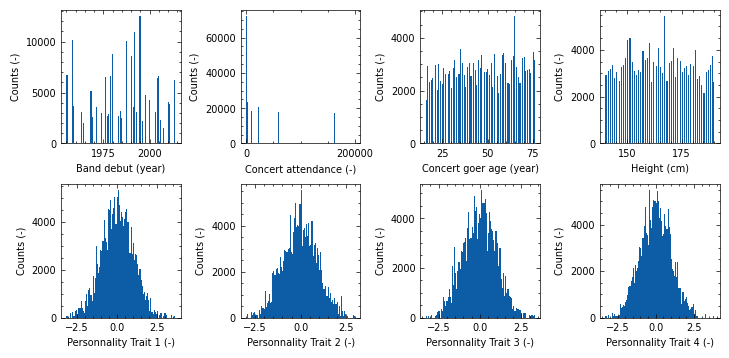

In [34]:
with plt.style.context(['mplstyle/nature.mplstyle']):

    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=[8.5, 4], gridspec_kw={'wspace': 0.5, 'hspace': 0.3})

    ax1.hist(train_data['Band Debut'], bins=100)
    ax1.set_ylabel('Counts (-)')
    ax1.set_xlabel('Band debut (year)')

    ax2.hist(train_data['Concert Attendance'], bins=100, range=(0, 200000))
    ax2.set_ylabel('Counts (-)')
    ax2.set_xlabel('Concert attendance (-)')

    ax3.hist(train_data['Concert Goer Age'], bins=100)
    ax3.set_ylabel('Counts (-)')
    ax3.set_xlabel('Concert goer age (year)')

    ax4.hist(train_data['Height (cm)'], bins=100)
    ax4.set_ylabel('Counts (-)')
    ax4.set_xlabel('Height (cm)')

    ax5.hist(train_data['Personnality Trait 1'], bins=100)
    ax5.set_ylabel('Counts (-)')
    ax5.set_xlabel('Personnality Trait 1 (-)')

    ax6.hist(train_data['Personnality Trait 2'], bins=100, range=(-3, 3))
    ax6.set_ylabel('Counts (-)')
    ax6.set_xlabel('Personnality Trait 2 (-)')

    ax7.hist(train_data['Personnality Trait 3'], bins=100)
    ax7.set_ylabel('Counts (-)')
    ax7.set_xlabel('Personnality Trait 3 (-)')

    ax8.hist(train_data['Personnality Trait 4'], bins=100)
    ax8.set_ylabel('Counts (-)')
    ax8.set_xlabel('Personnality Trait 4 (-)')

    plt.savefig('figures/feature_design.png', dpi=600, bbox_inches='tight')
